# 4IF Data Mining Lab

## Project detail
The project has been carried out in pairs, during 3 practical sessions lasting 4h each. We have implemented code using Python, which is commonly used for most data mining tasks thanks to many packages: `scikit-learn` (sklearn) providing many learning algorithms and clustering algorithms, as well as `Natural Language Toolkit` (nltk) to tackle text processing tasks. This document is an experimentation report stating our main results, as well as discussions about our different choices.

<a id="dependencies-section"></a>
## Dependencies 

We recommand usage of a [virtual environment](https://docs.python.org/3/library/venv.html) to run this notebook, since we are using many packages.

In [2]:
# installation of required libraries and dependencies
# numeric calculations
! pip install numpy==1.26.0 
# data frames 
! pip3 install pandas==2.1.1 
# machine learning algorithms 
! pip install scikit-learn==1.5.1 
! pip install scipy==1.12.0

# plotting 
! pip install plotly==5.24.1 
! pip install matplotlib==3.8.0 
! pip install plotly-express==0.4.1 
! pip install chart-studio==1.1.0 
# web app library 
! pip install streamlit==1.37.1 
#maping library
! pip install folium
# association rules
! pip install mlxtend==0.23.3

! pip install nbformat==5.9.2 

In [3]:
# load pandas to deal with the data
import pandas as pd
# plotting
import matplotlib.pyplot as plt

# mapping
import folium
import numpy as np

In [4]:
# opening data from the social network "flickr"
data = pd.read_csv("flickr_data2.csv", sep=",")
data.head()

/tmp/ipykernel_8533/3210405139.py:2: DtypeWarning: Columns (11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("flickr_data2.csv", sep=",")


,id,user,lat,long,tags,title,date_taken_minute,date_taken_hour,date_taken_day,date_taken_month,date_taken_year,date_upload_minute,date_upload_hour,date_upload_day,date_upload_month,date_upload_year,Unnamed: 16,Unnamed: 17,Unnamed: 18
0,4395181099,30624617@N03,45.754858,4.821710,"chair,lyon,rhône,chaise,rhônealpes",Chaises avec vue,11.0,15,28,2,2010,23,20,28.0,2,2010.0,NaN,NaN,NaN
1,4394748717,35853470@N00,45.753270,4.862953,NaN,NaN,51.0,17,28,2,2010,52,17,28.0,2,2010.0,NaN,NaN,NaN
2,4394694699,11817998@N05,45.760655,4.846564,"365,iphone",59/365 - R46 V103 B163,29.0,17,28,2,2010,33,17,28.0,2,2010.0,NaN,NaN,NaN
3,4394803790,11545749@N06,45.784000,4.874072,"nin,nineinchnails,gift,screening,toiou,avott",2010-01-29 Toiou Avott Lyon,15.0,20,28,1,2010,38,12,28.0,2,2010.0,NaN,NaN,NaN
4,4394803554,11545749@N06,45.784000,4.874072,"lyon,nin,nineinchnails,gift,screening,toiou,avott",2010-01-28 Toiou Avott Lyon,10.0,20,28,1,2010,38,12,28.0,2,2010.0,NaN,NaN,NaN


<a id="data-cleaning-section"></a>
## Data Cleaning 

### Incoherent Data

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420240 entries, 0 to 420239
Data columns (total 19 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   id                   420240 non-null  int64  
 1    user                420240 non-null  object 
 2    lat                 420240 non-null  float64
 3    long                420240 non-null  float64
 4    tags                316730 non-null  object 
 5    title               381911 non-null  object 
 6    date_taken_minute   420239 non-null  float64
 7    date_taken_hour     420240 non-null  int64  
 8    date_taken_day      420240 non-null  int64  
 9    date_taken_month    420240 non-null  int64  
 10   date_taken_year     420240 non-null  int64  
 11   date_upload_minute  420228 non-null  object 
 12   date_upload_hour    420238 non-null  object 
 13   date_upload_day     420238 non-null  float64
 14   date_upload_month   420240 non-null  int64  
 15   date_upload_year

We can see that a few columns aren't intersting, because there is no title and most of the rows have a `null` value for this attribute. We can suppose that these unwanted columns have apappeared due to poor formatting and conflicts with the `.csv` format. 

In [6]:
# all unwanted columns 
unnamed_columns = data.columns[data.columns.str.contains('^Unnamed')]

number_of_wrong_records = data[unnamed_columns].count().sum()
total_number_of_records = data["id"].count()

print(f"Percentages of rows with values in unwanted columns: {number_of_wrong_records*100/total_number_of_records:.3f}%")

Percentages of rows with values in unwanted columns: 0.034%


As the number of rows impacted by this error is very limited, we consider that removing these rows will be more efficient than trying to correct them.

In [7]:
data = data.loc[~data["Unnamed: 16"].notna(),:]
data = data.loc[~data["Unnamed: 17"].notna(),:]
data = data.loc[~data["Unnamed: 18"].notna(),:]
data.info()


<class 'pandas.core.frame.DataFrame'>
Index: 420098 entries, 0 to 420239
Data columns (total 19 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   id                   420098 non-null  int64  
 1    user                420098 non-null  object 
 2    lat                 420098 non-null  float64
 3    long                420098 non-null  float64
 4    tags                316635 non-null  object 
 5    title               381777 non-null  object 
 6    date_taken_minute   420098 non-null  float64
 7    date_taken_hour     420098 non-null  int64  
 8    date_taken_day      420098 non-null  int64  
 9    date_taken_month    420098 non-null  int64  
 10   date_taken_year     420098 non-null  int64  
 11   date_upload_minute  420098 non-null  object 
 12   date_upload_hour    420098 non-null  object 
 13   date_upload_day     420098 non-null  float64
 14   date_upload_month   420098 non-null  int64  
 15   date_upload_year    4

Then we can remove corresponding columns.

In [8]:
data=data.drop(columns=unnamed_columns)
data.columns

Index(['id', ' user', ' lat', ' long', ' tags', ' title', ' date_taken_minute',
       ' date_taken_hour', ' date_taken_day', ' date_taken_month',
       ' date_taken_year', ' date_upload_minute', ' date_upload_hour',
       ' date_upload_day', ' date_upload_month', ' date_upload_year'],
      dtype='object')

We also can see a problem with the name of atributes. Except for the `"id"`, each column name begins with a spacebar character (ex: `" user"`), which isn't convenient for the following steps. We can easily get rid of it:

In [9]:
data=data.rename(columns=lambda x: x.strip())
data.columns

Index(['id', 'user', 'lat', 'long', 'tags', 'title', 'date_taken_minute',
       'date_taken_hour', 'date_taken_day', 'date_taken_month',
       'date_taken_year', 'date_upload_minute', 'date_upload_hour',
       'date_upload_day', 'date_upload_month', 'date_upload_year'],
      dtype='object')

<a id="missing-vals"></a>
### Missing Values

We can see that a few records don't have value for `"tags"` and/or `"title"`. It is not a problem while we are not considering [NLP](https://en.wikipedia.org/wiki/Natural_language_processing). We still need to keep that in mind for later treatments. Besides we can note another `"null"` value for one record on the attribute: `"date_upload_year"`. 

In [10]:
data[data["date_upload_year"].isnull()]

,id,user,lat,long,tags,title,date_taken_minute,date_taken_hour,date_taken_day,date_taken_month,date_taken_year,date_upload_minute,date_upload_hour,date_upload_day,date_upload_month,date_upload_year
42366,5464485473,35635047@N03,45.765517,4.76651,"lundimatin,lyondefi38nuit",une lundi matin comme tout les autre ;-(25,6.0,21,2,2011,11,15,21,2.0,2011,NaN


In [11]:
data = data.loc[~data["date_upload_year"].isnull(),:]
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 420097 entries, 0 to 420239
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  420097 non-null  int64  
 1   user                420097 non-null  object 
 2   lat                 420097 non-null  float64
 3   long                420097 non-null  float64
 4   tags                316634 non-null  object 
 5   title               381776 non-null  object 
 6   date_taken_minute   420097 non-null  float64
 7   date_taken_hour     420097 non-null  int64  
 8   date_taken_day      420097 non-null  int64  
 9   date_taken_month    420097 non-null  int64  
 10  date_taken_year     420097 non-null  int64  
 11  date_upload_minute  420097 non-null  object 
 12  date_upload_hour    420097 non-null  object 
 13  date_upload_day     420097 non-null  float64
 14  date_upload_month   420097 non-null  int64  
 15  date_upload_year    420097 non-null  fl

<a id="duplicates"></a>
### Duplicates

Most of the records are duplicated, because a user can upload many pictures of the same place in a short amount of time (example below). But we only need one occurrence of metadata for a given position at a specific moment. Hence we use the [`duplicated()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.duplicated.html) method.

In [12]:
# only checking the duplicates for the selected attributes
columns_for_duplicates=['user', 'lat', 'long','date_taken_hour',
                        'date_taken_day', 'date_taken_month',
                        'date_taken_year', 'date_upload_minute',
                        'date_upload_hour', 'date_upload_day',
                        'date_upload_month', 'date_upload_year']
data=data.drop_duplicates(subset=columns_for_duplicates)

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 125445 entries, 0 to 420239
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  125445 non-null  int64  
 1   user                125445 non-null  object 
 2   lat                 125445 non-null  float64
 3   long                125445 non-null  float64
 4   tags                91436 non-null   object 
 5   title               112193 non-null  object 
 6   date_taken_minute   125445 non-null  float64
 7   date_taken_hour     125445 non-null  int64  
 8   date_taken_day      125445 non-null  int64  
 9   date_taken_month    125445 non-null  int64  
 10  date_taken_year     125445 non-null  int64  
 11  date_upload_minute  125445 non-null  object 
 12  date_upload_hour    125445 non-null  object 
 13  date_upload_day     125445 non-null  float64
 14  date_upload_month   125445 non-null  int64  
 15  date_upload_year    125445 non-null  fl

We can now realise that a lot of data wasn't usefull for any relevant analyse. Most of the cleaning work is now done so cleaned data can be saved in a new dataframe.

In [14]:
number_of_records_after_cleaning = data["id"].count()
records_kept_percentage = number_of_records_after_cleaning*100/total_number_of_records
print(f"Percentages of records kept after cleaning: {records_kept_percentage:.3f}%")

Percentages of records kept after cleaning: 29.851%


In [15]:
# save to file
data.to_csv('./data_cleaned.csv',index=False)
data_cleaned = pd.read_csv("data_cleaned.csv", sep=",")


In [16]:
m = folium.Map([45.762611,4.832805	], zoom_start=12)

data_sample = data_cleaned.sample(1000)

for index, row in data_sample.iterrows():
    folium.Marker(
        location=[row["lat"],row["long"]],
        icon=folium.DivIcon(html=f"""<svg width="20px" height="20px" viewBox="0 0 24 24" fill="none" xmlns="http://www.w3.org/2000/svg">
        <path d="M12 9.5C13.3807 9.5 14.5 10.6193 14.5 12C14.5 13.3807 13.3807 14.5 12 14.5C10.6193 14.5 9.5 13.3807 9.5 12C9.5 10.6193 10.6193 9.5 12 9.5Z" fill="#8b0000"/>
        </svg>""")
    ).add_to(m)

m

To obtain the statistical summary of the dataframe, we can use [`describe()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.describe.html). Some of the values aren't relevant, but we can focus on certain metrics to explore the dataset.

In [17]:
# summarised statistics
data_summary = data_cleaned.describe()
data_summary

,id,lat,long,date_taken_minute,date_taken_hour,date_taken_day,date_taken_month,date_taken_year,date_upload_minute,date_upload_hour,date_upload_day,date_upload_month,date_upload_year
count,1.254450e+05,125445.000000,125445.000000,125445.000000,125445.000000,125445.000000,125445.000000,125445.000000,125445.000000,125445.000000,125445.000000,125445.000000,125445.000000
mean,1.943034e+10,45.764326,4.837632,29.426075,14.773391,15.126717,7.126629,2013.891945,29.471410,14.687249,15.652525,6.831879,2014.238072
std,1.415394e+10,0.023295,0.029665,17.576730,4.992414,8.672270,3.489012,3.209435,17.262973,6.615819,8.517690,3.616347,2.854888
min,3.066675e+08,45.655200,4.720312,0.000000,0.000000,1.000000,1.000000,1926.000000,0.000000,0.000000,1.000000,1.000000,2009.000000
25%,7.074764e+09,45.757508,4.826248,14.000000,12.000000,8.000000,4.000000,2012.000000,15.000000,11.000000,9.000000,4.000000,2012.000000
50%,1.421363e+10,45.762611,4.832805,30.000000,15.000000,14.000000,7.000000,2014.000000,30.000000,16.000000,15.000000,7.000000,2014.000000
75%,3.136933e+10,45.770404,4.842975,45.000000,18.000000,23.000000,10.000000,2017.000000,44.000000,20.000000,23.000000,10.000000,2017.000000
max,4.914809e+10,45.854950,5.006709,59.000000,23.000000,31.000000,12.000000,2238.000000,59.000000,23.000000,31.000000,12.000000,2019.000000


We can see that values for dates are compliant with expectations (example: `"date_taken_hour"` between 0h and 23h with a mean around 15h). Yet it seems that an error appeard for the maximum value of `"date_taken_year"`. Indeed, it's unlikely that a photo was taken in the year 2238.

In [18]:
data_cleaned[data_cleaned["date_taken_year"] == 2238]

,id,user,lat,long,tags,title,date_taken_minute,date_taken_hour,date_taken_day,date_taken_month,date_taken_year,date_upload_minute,date_upload_hour,date_upload_day,date_upload_month,date_upload_year
32647,7690629716,83991262@N03,45.750606,4.835368,NaN,NaN,46.0,5,16,2,2238,57.0,13,1.0,8,2012.0


As we can't determine the correct value for this record, we better remove it from the dataset.

In [19]:
index=data_cleaned[data_cleaned['date_taken_year'] == 2238].index
data_cleaned = data_cleaned.drop(index=index,axis=1)
taken_years = data_cleaned["date_taken_year"].unique()
uploded_years = data_cleaned["date_upload_year"].unique()
print(f" When pictures are taken : {taken_years}\n")
print(f" When pictures are uploaded : {uploded_years}")

 When pictures are taken : [2010 2009 2007 2008 2006 2002 2004 2005 1976 1995 2012 1998 1989 1957
 1977 1979 2014 2001 1991 2011 2013 1980 2003 1985 1981 1997 1974 2015
 1926 1930 1938 1935 1968 1972 1970 1983 1988 1973 2000 2017 2016 1969
 1993 2018 1982 1965 1996 1966 2019]

 When pictures are uploaded : [2010. 2009. 2011. 2012. 2013. 2014. 2015. 2016. 2017. 2018. 2019.]


It's interesting to note that pictures can have been taken a long time before the year of upload. This will be taken into account for the last part of this project (considering the effect of time on areas of interest).

We can now save the cleaned data again and crate another dataframe only dedicated to spacial clusturing.

In [20]:
data_cleaned.to_csv('./data_cleaned.csv',index=False)
coordinates_df = data_cleaned[["id", "lat", "long"]]
coordinates_df

,id,lat,long
0,4395181099,45.754858,4.821710
1,4394748717,45.753270,4.862953
2,4394694699,45.760655,4.846564
3,4394803790,45.784000,4.874072
4,4394566432,45.755940,4.833158
...,...,...,...
125440,44402328654,45.758316,4.825197
125441,44210748275,45.762635,4.837299
125442,45122361361,45.763657,4.836012
125443,45073351222,45.763657,4.836012


## Prepare Data for Clustering

Even though in our case the attributes have comparable scales, let's apply a [`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html). Recall, that for a given value `x`, a standard score is given by $z = \frac{x - mean(\mathbf{x})}{std(\mathbf{x})}$ 

In [21]:
# scaler
from sklearn.preprocessing import StandardScaler

In [22]:
# Scale the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(coordinates_df[["lat", "long"]])
# show
print(scaled_data)
# create a DataFrame
scaled_coordinates_df = pd.DataFrame(data=coordinates_df)
scaled_coordinates_df[['scaled_lat', 'scaled_long']] = scaled_data
scaled_coordinates_df

[[-0.4064356  -0.53671938]
 [-0.47460442  0.85355049]
 [-0.15758507  0.30108988]
 ...
 [-0.02871681 -0.05460994]
 [-0.02871681 -0.05460994]
 [-0.26378762 -0.19096379]]


,id,lat,long,scaled_lat,scaled_long
0,4395181099,45.754858,4.821710,-0.406436,-0.536719
1,4394748717,45.753270,4.862953,-0.474604,0.853550
2,4394694699,45.760655,4.846564,-0.157585,0.301090
3,4394803790,45.784000,4.874072,0.844557,1.228363
4,4394566432,45.755940,4.833158,-0.359988,-0.150816
...,...,...,...,...,...
125440,44402328654,45.758316,4.825197,-0.257992,-0.419175
125441,44210748275,45.762635,4.837299,-0.072589,-0.011226
125442,45122361361,45.763657,4.836012,-0.028717,-0.054610
125443,45073351222,45.763657,4.836012,-0.028717,-0.054610


## Apply k-means Clustering

To apply **k-means clustering**, we are going to use [`sklearn.cluster.KMeans`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html).

In [23]:
# k-means
from sklearn.cluster import KMeans

As k-means clusering relies on the parameter `k`, we can use the `Elbow Method` to approach the optimal value for `k`. `inertia` is used to measure the distance between each record from the center of its cluster.

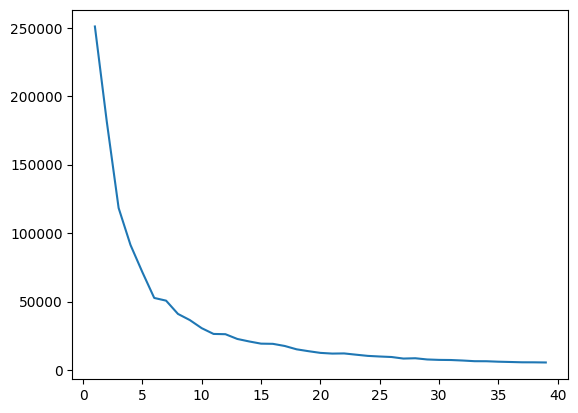

[250887.9999999935,
 181575.0580852733,
 118358.97460792468,
 91381.47446869205,
 71538.964609211,
 52701.47205323004,
 50717.39787108947,
 41033.22598326803,
 36539.54036352379,
 30630.948583700178,
 26418.945070252725,
 26221.78444444248,
 22760.490144532418,
 20929.838467472364,
 19328.556033204943,
 19188.44969788919,
 17624.476288364684,
 15187.519132884034,
 13823.190147726098,
 12586.995127428156,
 12071.5855282659,
 12184.43323737111,
 11274.119951548786,
 10392.739741597688,
 9940.549333615942,
 9571.595965037486,
 8438.062216697163,
 8666.409658072711,
 7779.88793350815,
 7468.992889983756,
 7374.391990362132,
 7004.218466588329,
 6520.0666601151215,
 6482.198106223924,
 6148.018837273019,
 5937.279244905807,
 5713.203067164905,
 5690.3860236812425,
 5578.814451641626]

In [24]:
inertias = []
for i in range(1,40):
  kmeans=KMeans(n_clusters=i,init='k-means++')
  kmeans.fit(scaled_coordinates_df[["scaled_lat", "scaled_long"]])
  inertias.append(kmeans.inertia_)

plt.plot(range(1,40),inertias)
plt.show()
inertias

It seems that optimal values for `k` are arround 8 clusters. Thus let's try to visualize the effect of this value.

In [ ]:
k = 8
kmeans=KMeans(n_clusters=k,init='k-means++')
kmeans.fit(scaled_coordinates_df[["scaled_lat", "scaled_long"]])
scaled_coordinates_df["k_means_clusters"] = kmeans.labels_
scaled_coordinates_df


,id,lat,long,scaled_lat,scaled_long,k_means_clusters
0,4395181099,45.754858,4.821710,-0.406436,-0.536719,4
1,4394748717,45.753270,4.862953,-0.474604,0.853550,1
2,4394694699,45.760655,4.846564,-0.157585,0.301090,4
3,4394803790,45.784000,4.874072,0.844557,1.228363,1
4,4394566432,45.755940,4.833158,-0.359988,-0.150816,4
...,...,...,...,...,...,...
125440,44402328654,45.758316,4.825197,-0.257992,-0.419175,4
125441,44210748275,45.762635,4.837299,-0.072589,-0.011226,4
125442,45122361361,45.763657,4.836012,-0.028717,-0.054610,4
125443,45073351222,45.763657,4.836012,-0.028717,-0.054610,4


In [26]:
m = folium.Map([45.762611,4.832805], zoom_start=12)

scaled_coordinates_sample = scaled_coordinates_df.sample(5000)

colors = plt.cm.get_cmap("hsv", k)

cluster_colors = {cluster: f"#{int(colors(i)[0]*255):02x}{int(colors(i)[1]*255):02x}{int(colors(i)[2]*255):02x}" 
                  for i, cluster in enumerate(sorted(scaled_coordinates_sample["k_means_clusters"].unique()))}

for index, row in scaled_coordinates_sample.iterrows():
    cluster_color = cluster_colors[row["k_means_clusters"]]
    folium.Marker(
        location=[row["lat"],row["long"]],
        icon=folium.DivIcon(html=f"""<svg width="20px" height="20px" viewBox="0 0 24 24" fill="none" xmlns="http://www.w3.org/2000/svg">
        <path d="M12 9.5C13.3807 9.5 14.5 10.6193 14.5 12C14.5 13.3807 13.3807 14.5 12 14.5C10.6193 14.5 9.5 13.3807 9.5 12C9.5 10.6193 10.6193 9.5 12 9.5Z" fill="{cluster_color}"/>
        </svg>""")
    ).add_to(m)

centers = scaler.inverse_transform(kmeans.cluster_centers_)

for i in centers:
    folium.Marker(
        location=[i[0],i[1]],
        icon=folium.DivIcon(html=f"""<svg width="60px" height="60px" viewBox="0 0 24 24" fill="none" xmlns="http://www.w3.org/2000/svg">
        <path d="M12 9.5C13.3807 9.5 14.5 10.6193 14.5 12C14.5 13.3807 13.3807 14.5 12 14.5C10.6193 14.5 9.5 13.3807 9.5 12C9.5 10.6193 10.6193 9.5 12 9.5Z" fill="#0b5555"/>
        </svg>""")
    ).add_to(m)

m.save("kmeans_clustering.html")

/tmp/ipykernel_8533/3919802612.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("hsv", k)


It seems pretty obvious that 8 isn't a good value for the number of cluster, because there is probably more than 8 points of interest in Lyon... We could have expected for the main districts of Lyon to be separated clearly but it isn't even the case.

We could try another method to find a better value for `k` (as the silhouette coefficient), but it would be tedious because we can only evaluate the results one by one for each values of `k`.

## Apply Hierarchical Clustering

**QUESTIONS**

* Apply Agglomerative clustering with different linkage options: complete, average, single. 

*Hint*: use [`sklearn.cluster.AgglomerativeClustering`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html)
* For each linkage, draw a dendrogram.
* Calculate the silhouette scores

In [27]:
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering

In [173]:
hierarchical_coordinates_sample = scaled_coordinates_df.sample(5000)

threshold = 1.2
print(f"Threshold: {threshold}")
agglomerative_clustering = AgglomerativeClustering(n_clusters=None,distance_threshold=threshold).fit(hierarchical_coordinates_sample[["scaled_lat", "scaled_long"]])
labels = agglomerative_clustering.labels_
hierarchical_coordinates_sample["agglomerative_clusters"] = labels
print(f"Number of clusters: {len(set(labels))- (1 if -1 in labels else 0)}")

Threshold: 1.2
Number of clusters: 118


In [29]:
hierarchical_coordinates_sample.head()

,id,lat,long,scaled_lat,scaled_long,k_means_clusters,agglomerative_clusters
113012,46515924524,45.756925,4.838130,-0.317705,0.016786,4,4
116731,46833029125,45.770302,4.830552,0.256536,-0.238662,4,22
4121,4604024746,45.737602,4.817783,-1.147192,-0.669096,0,0
25640,6835570088,45.772105,4.808400,0.333934,-0.985389,4,7
49958,9741298469,45.768595,4.835675,0.183259,-0.065970,4,5


{'icoord': [[5.0, 5.0, 15.0, 15.0],
  [35.0, 35.0, 45.0, 45.0],
  [25.0, 25.0, 40.0, 40.0],
  [10.0, 10.0, 32.5, 32.5],
  [85.0, 85.0, 95.0, 95.0],
  [75.0, 75.0, 90.0, 90.0],
  [65.0, 65.0, 82.5, 82.5],
  [155.0, 155.0, 165.0, 165.0],
  [145.0, 145.0, 160.0, 160.0],
  [135.0, 135.0, 152.5, 152.5],
  [125.0, 125.0, 143.75, 143.75],
  [115.0, 115.0, 134.375, 134.375],
  [265.0, 265.0, 275.0, 275.0],
  [255.0, 255.0, 270.0, 270.0],
  [245.0, 245.0, 262.5, 262.5],
  [235.0, 235.0, 253.75, 253.75],
  [225.0, 225.0, 244.375, 244.375],
  [215.0, 215.0, 234.6875, 234.6875],
  [205.0, 205.0, 224.84375, 224.84375],
  [195.0, 195.0, 214.921875, 214.921875],
  [185.0, 185.0, 204.9609375, 204.9609375],
  [285.0, 285.0, 295.0, 295.0],
  [345.0, 345.0, 355.0, 355.0],
  [335.0, 335.0, 350.0, 350.0],
  [325.0, 325.0, 342.5, 342.5],
  [315.0, 315.0, 333.75, 333.75],
  [305.0, 305.0, 324.375, 324.375],
  [290.0, 290.0, 314.6875, 314.6875],
  [194.98046875, 194.98046875, 302.34375, 302.34375],
  [175.0, 

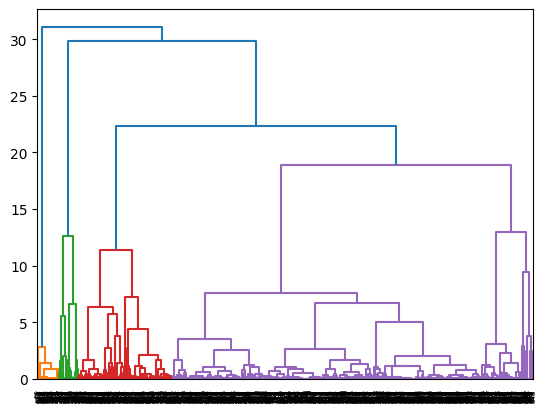

In [30]:
linkage_matrix = linkage(hierarchical_coordinates_sample[["scaled_lat", "scaled_long"]], method='ward')
dendrogram(
    linkage_matrix,
    truncate_mode='level',
    p=30
)

In [123]:
# silhouette scores
from sklearn.metrics import silhouette_score, silhouette_samples

In [124]:
def find_best_threshold( thresholds ):
    silhouette_scores = []
    n_clusters_list = []

    for threshold in thresholds:

        agglomerative_clustering = AgglomerativeClustering(
            n_clusters=None, distance_threshold=threshold
        ).fit(hierarchical_coordinates_sample[["scaled_lat", "scaled_long"]])
        
        labels = agglomerative_clustering.labels_
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_clusters_list.append(n_clusters)

        if n_clusters > 1:
            score = silhouette_score(hierarchical_coordinates_sample[["scaled_lat", "scaled_long"]], labels)
        else:
            score = -1
        silhouette_scores.append(score)

    df = pd.DataFrame({"scores": silhouette_scores, "nb_clust": n_clusters_list})
    return(df)

In [127]:
thresholds = np.linspace(0.1, 6.0, 1000)
hierarchical_silhouette_test1 = find_best_threshold(thresholds)

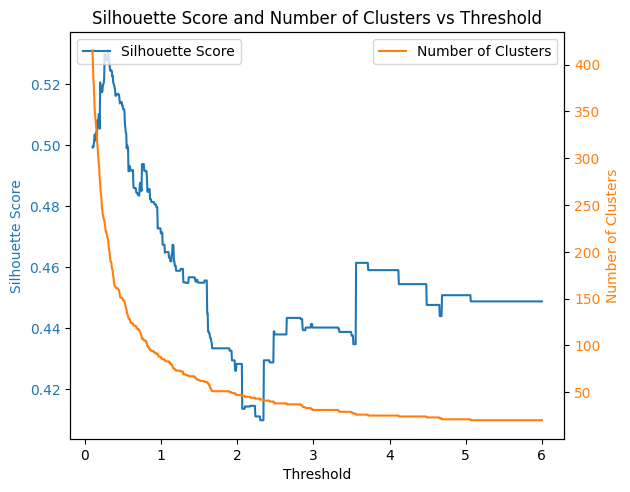

In [128]:
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Threshold')
ax1.set_ylabel('Silhouette Score', color=color)
ax1.plot(thresholds, hierarchical_silhouette_test1["scores"], label='Silhouette Score', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
color = 'tab:orange'
ax2.set_ylabel('Number of Clusters', color=color)
ax2.plot(thresholds, hierarchical_silhouette_test1["nb_clust"], label='Number of Clusters', color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc='upper right')

fig.tight_layout()
plt.title('Silhouette Score and Number of Clusters vs Threshold')
plt.show()

It appears that silhouette score is higher for values of threshold between 0.1 and 1. Let's try plotting silhouette score again in this interval.

In [129]:
thresholds = np.linspace(0.1, 1, 1000)
hierarchical_silhouette_test2 = find_best_threshold(thresholds)

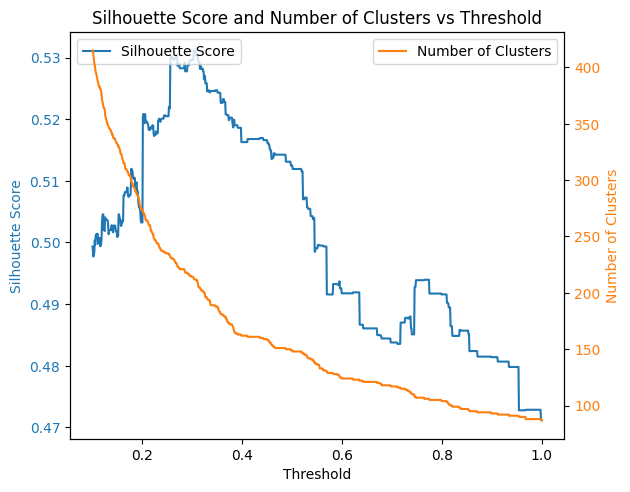

In [130]:
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Threshold')
ax1.set_ylabel('Silhouette Score', color=color)
ax1.plot(thresholds, hierarchical_silhouette_test2["scores"], label='Silhouette Score', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
color = 'tab:orange'
ax2.set_ylabel('Number of Clusters', color=color)
ax2.plot(thresholds, hierarchical_silhouette_test2["nb_clust"], label='Number of Clusters', color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc='upper right')

fig.tight_layout()
plt.title('Silhouette Score and Number of Clusters vs Threshold')
plt.show()

There is no significant variation of silhouette score for low threshold. However, the number of clusters varies a lot. We can expect to have more than 100 clusters, thus picking a threshold value under 0.5. Besides we can check results with a threshold of 0.17 to maximize the number of clusters for our qualitative verification (which is the only remaining mean of verifiation).

To ensure that locations given by the clusters are precise enough, we can reject any sample with a low silhouette score. But with this filtering there is still some noise because of clusters containing few samples which are more likely to have greater silhouette score. As we suppose that small clusters aren't relevant we can remove them. 

In [164]:
def find_best_threshold2( thresholds ):
    silhouette_scores = []
    n_clusters_list = []
    min_silhouette_list = []

    for threshold in thresholds:

        agglomerative_clustering = AgglomerativeClustering(
            n_clusters=None, distance_threshold=threshold
        ).fit(hierarchical_coordinates_sample[["scaled_lat", "scaled_long"]])
        
        labels = agglomerative_clustering.labels_
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_clusters_list.append(n_clusters)

        if n_clusters > 1:
            score = silhouette_score(hierarchical_coordinates_sample[["scaled_lat", "scaled_long"]], labels)
            silhouettes_vector = silhouette_samples(hierarchical_coordinates_sample[["scaled_lat", "scaled_long"]], labels)
            silhouettes_df = pd.DataFrame({"labels": labels, "silhouette_scores": silhouettes_vector})
            silhouettes_df = silhouettes_df[silhouettes_df["silhouette_scores"] > 0]
            max_silhouette_list = silhouettes_df.groupby("labels")["silhouette_scores"].max().values
            min_silhouette_list.append(max_silhouette_list.min())
        else:
            score = -1
        silhouette_scores.append(score)
    df = pd.DataFrame({"scores": silhouette_scores, "min_silhouettes": min_silhouette_list})
    return(df)

In [174]:
thresholds = np.linspace(0.1, 1, 100)
hierarchical_silhouette_test2 = find_best_threshold2(thresholds)

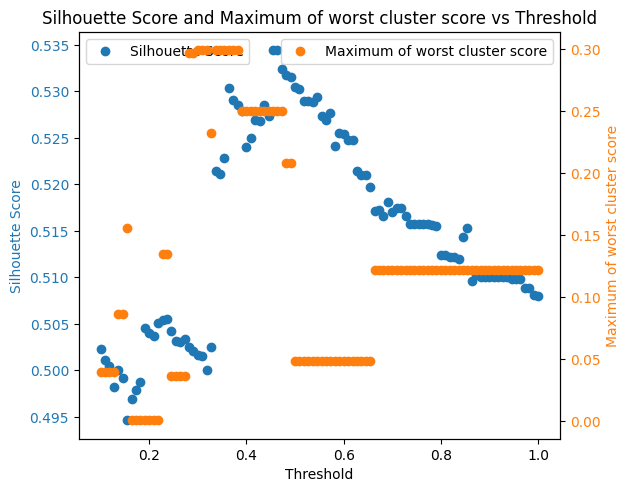

In [178]:
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Threshold')
ax1.set_ylabel('Silhouette Score', color=color)
ax1.plot(thresholds, hierarchical_silhouette_test2["scores"], label='Silhouette Score', marker='o',linestyle='', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
color = 'tab:orange'
ax2.set_ylabel('Maximum of worst cluster score', color=color)
ax2.plot(thresholds, hierarchical_silhouette_test2["min_silhouettes"], label='Maximum of worst cluster score', marker='o',linestyle='', color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc='upper right')

fig.tight_layout()
plt.title('Silhouette Score and Maximum of worst cluster score vs Threshold')
plt.show()

In [186]:
hierarchical_coordinates_sample = scaled_coordinates_df.sample(20000)

agglomerative_clustering = AgglomerativeClustering(n_clusters=None,distance_threshold=0.52).fit(hierarchical_coordinates_sample[["scaled_lat", "scaled_long"]])
labels = agglomerative_clustering.labels_
hierarchical_coordinates_sample["agglomerative_clusters"] = labels
hierarchical_coordinates_sample["agglomerative_clusters"].nunique()

hierarchical_coordinates_sample["silhouette_score"] = silhouette_samples(
    hierarchical_coordinates_sample[["scaled_lat", "scaled_long"]],
    hierarchical_coordinates_sample["agglomerative_clusters"])

In [184]:
filtered_hierarchical = hierarchical_coordinates_sample[hierarchical_coordinates_sample["silhouette_score"]>0.5]

number_of_samples_by_cluster = hierarchical_coordinates_sample.groupby("agglomerative_clusters").count()
too_small_clusters_id = number_of_samples_by_cluster[number_of_samples_by_cluster["id"] < 10].index
filtered_hierarchical = filtered_hierarchical[~filtered_hierarchical["agglomerative_clusters"].isin(too_small_clusters_id)]

nb_clusters = filtered_hierarchical["agglomerative_clusters"].nunique()

In [187]:
m = folium.Map([45.762611,4.832805], zoom_start=12)

colors = plt.cm.get_cmap("hsv", nb_clusters)

cluster_colors = {cluster: f"#{int(colors(i)[0]*255):02x}{int(colors(i)[1]*255):02x}{int(colors(i)[2]*255):02x}" 
                  for i, cluster in enumerate(filtered_hierarchical["agglomerative_clusters"].unique())}

for index, row in filtered_hierarchical.iterrows():
    cluster_color = cluster_colors[row["agglomerative_clusters"]]
    folium.Marker(
        location=[row["lat"],row["long"]],
        popup=row["agglomerative_clusters"],
        icon=folium.DivIcon(html=f"""<svg width="50px" height="50px" viewBox="0 0 24 24" fill="none" xmlns="http://www.w3.org/2000/svg">
        <path d="M12 9.5C13.3807 9.5 14.5 10.6193 14.5 12C14.5 13.3807 13.3807 14.5 12 14.5C10.6193 14.5 9.5 13.3807 9.5 12C9.5 10.6193 10.6193 9.5 12 9.5Z" fill="{cluster_color}"/>
        </svg>""")
    ).add_to(m)

# Display the map
m.save("hierarchical_clustering.html")

/tmp/ipykernel_8533/311799708.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("hsv", nb_clusters)


In [94]:
# Create a map centered at the given coordinates
m = folium.Map([45.762611,4.832805], zoom_start=12)
                                
nb_clusters = hierarchical_coordinates_sample["agglomerative_clusters"].nunique()

colors = plt.cm.get_cmap("hsv", nb_clusters)

cluster_colors = {cluster: f"#{int(colors(i)[0]*255):02x}{int(colors(i)[1]*255):02x}{int(colors(i)[2]*255):02x}" 
                  for i, cluster in enumerate(sorted(hierarchical_coordinates_sample["agglomerative_clusters"].unique()))}

for index, row in hierarchical_coordinates_sample.iterrows():
    cluster_color = cluster_colors[row["agglomerative_clusters"]]
    folium.Marker(
        location=[row["lat"],row["long"]],
        popup=row["agglomerative_clusters"],
        icon=folium.DivIcon(html=f"""<svg width="50px" height="50px" viewBox="0 0 24 24" fill="none" xmlns="http://www.w3.org/2000/svg">
        <path d="M12 9.5C13.3807 9.5 14.5 10.6193 14.5 12C14.5 13.3807 13.3807 14.5 12 14.5C10.6193 14.5 9.5 13.3807 9.5 12C9.5 10.6193 10.6193 9.5 12 9.5Z" fill="{cluster_color}"/>
        </svg>""")
    ).add_to(m)

# Display the map
m.save("hierarchical_clustering.html")

/tmp/ipykernel_8745/4033478857.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("hsv", nb_clusters)


## Task 7: Apply DBSCAN

**QUESTIONS**

* Apply [sklearn.cluster.DBSCAN](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html) algorithm
* Identify the best values for `eps` and `min_sanples` by varying the values within a range and by using Silhouette coefficient
* Apply DBSCAN with the best parameters found
* Print number of clusters and noise points

In [193]:
# DBSCAN
from sklearn.cluster import DBSCAN

In [232]:
def find_best_epsilon( epsilons , min_samples):
    silhouette_scores = []
    n_clusters_list = []
    min_silhouette_list = []

    for eps in epsilons:
        clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(DBSCAN_coordinates_sample[["scaled_lat", "scaled_long"]])
        
        labels = clustering.labels_
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_clusters_list.append(n_clusters)

        if n_clusters > 1:
            score = silhouette_score(DBSCAN_coordinates_sample[["scaled_lat", "scaled_long"]], labels)
            silhouettes_vector = silhouette_samples(DBSCAN_coordinates_sample[["scaled_lat", "scaled_long"]], labels)
            silhouettes_df = pd.DataFrame({"labels": labels, "silhouette_scores": silhouettes_vector})
            silhouettes_df = silhouettes_df[silhouettes_df["silhouette_scores"] > 0]
            max_silhouette_list = silhouettes_df.groupby("labels")["silhouette_scores"].max().values
            min_silhouette_list.append(max_silhouette_list.min())
        else:
            score = -1
        silhouette_scores.append(score)
    df = pd.DataFrame({"scores": silhouette_scores, "min_silhouettes": min_silhouette_list})
    return(df)

In [309]:
DBSCAN_coordinates_sample = scaled_coordinates_df.sample(1000)
epsilons = np.linspace(0.01, 0.1, 300)
DBSCAN_silhouette_test = find_best_epsilon(epsilons, 5)

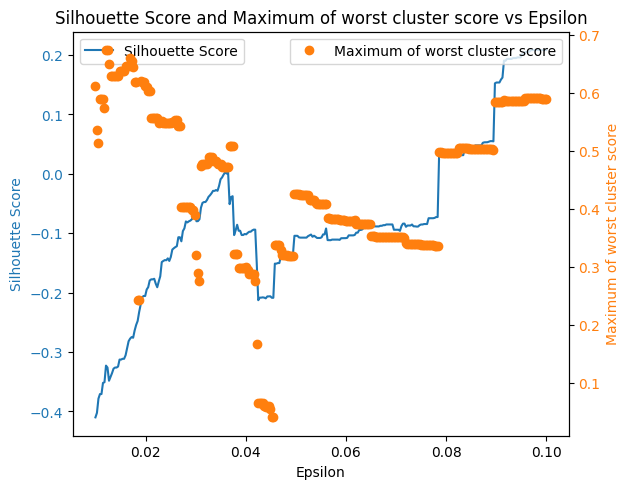

In [310]:
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Epsilon')
ax1.set_ylabel('Silhouette Score', color=color)
ax1.plot(epsilons, DBSCAN_silhouette_test["scores"], label='Silhouette Score', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
color = 'tab:orange'
ax2.set_ylabel('Maximum of worst cluster score', color=color)
ax2.plot(epsilons, DBSCAN_silhouette_test["min_silhouettes"], label='Maximum of worst cluster score', marker='o',linestyle='', color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc='upper right')

fig.tight_layout()
plt.title('Silhouette Score and Maximum of worst cluster score vs Epsilon')
plt.show()

In [306]:
DBSCAN_coordinates_sample = scaled_coordinates_df.sample(30000)

clustering = DBSCAN(eps=0.25, min_samples=5).fit(DBSCAN_coordinates_sample[["scaled_lat", "scaled_long"]])
labels = clustering.labels_
DBSCAN_coordinates_sample["DBSCAN_clusters"] = labels
DBSCAN_coordinates_sample["DBSCAN_clusters"].nunique()

DBSCAN_coordinates_sample["silhouette_score"] = silhouette_samples(
    DBSCAN_coordinates_sample[["scaled_lat", "scaled_long"]],
    DBSCAN_coordinates_sample["DBSCAN_clusters"])

In [307]:
#filtered_DBSCAN = DBSCAN_coordinates_sample[DBSCAN_coordinates_sample["silhouette_score"]>0.5]
min_sample_by_cluster = 15
max_sample_by_cluster = 100

cluster_counts = DBSCAN_coordinates_sample["DBSCAN_clusters"].map(DBSCAN_coordinates_sample["DBSCAN_clusters"].value_counts())

filtered_DBSCAN = DBSCAN_coordinates_sample[cluster_counts >= min_sample_by_cluster]
filtered_DBSCAN = filtered_DBSCAN[cluster_counts <= max_sample_by_cluster]
filtered_DBSCAN = filtered_DBSCAN[filtered_DBSCAN["DBSCAN_clusters"] != -1]

nb_clusters = filtered_DBSCAN["DBSCAN_clusters"].nunique()

/tmp/ipykernel_8533/4670107.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_DBSCAN = filtered_DBSCAN[cluster_counts <= max_sample_by_cluster]


In [308]:
m = folium.Map([45.762611,4.832805], zoom_start=12)

colors = plt.cm.get_cmap("hsv", nb_clusters)

cluster_colors = {cluster: f"#{int(colors(i)[0]*255):02x}{int(colors(i)[1]*255):02x}{int(colors(i)[2]*255):02x}" 
                  for i, cluster in enumerate(filtered_DBSCAN["DBSCAN_clusters"].unique())}

for index, row in filtered_DBSCAN.iterrows():
    cluster_color = cluster_colors[row["DBSCAN_clusters"]]
    folium.Marker(
        location=[row["lat"],row["long"]],
        popup=row["DBSCAN_clusters"],
        icon=folium.DivIcon(html=f"""<svg width="50px" height="50px" viewBox="0 0 24 24" fill="none" xmlns="http://www.w3.org/2000/svg">
        <path d="M12 9.5C13.3807 9.5 14.5 10.6193 14.5 12C14.5 13.3807 13.3807 14.5 12 14.5C10.6193 14.5 9.5 13.3807 9.5 12C9.5 10.6193 10.6193 9.5 12 9.5Z" fill="{cluster_color}"/>
        </svg>""")
    ).add_to(m)

# Display the map
m.save("dbscan_clustering.html")

/tmp/ipykernel_8533/320309410.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("hsv", nb_clusters)
